In [90]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 05a
### Neural Network with :
- One hidden layer 
- ${Tanh}$ activation function
- **multi-class**

<img src='/home/dai/Documents/DNN/7. DNN/images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [91]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

#changes------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#changes------------------------------

%matplotlib inline

In [92]:
###----------------
### Some parameters
###----------------

inpDir = '../DNN/7. DNN/input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 3001 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

## Helper Functions

In [93]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], 
               c=np.argmax(y_tr, axis = 1), # y_tr has two columns 
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], 
               c=np.argmax(y_ts, axis = 1), # y_tr has two columns ,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )


## Generate Data Set

FIFA 2019 Dataset

In [94]:
data_df = pd.read_csv('fifa_2019.csv')

In [95]:
for col in data_df.columns:
    print(f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [96]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 89, dtype: int64

In [97]:
data_df = data_df[data_df['Position'].notnull()]
data_df.shape

(18147, 89)

In [98]:
data_df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [99]:
rel_columns = ['Position','Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

"""['Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
        'Release Clause']"""

"['Name', 'Age', 'Photo', 'Nationality', 'Flag',\n       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',\n       'Preferred Foot', 'International Reputation', 'Weak Foot',\n       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',\n       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',\n       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',\n       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',\n       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',\n        'Release Clause']"

In [100]:
data_df = data_df[rel_columns]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [101]:
data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [102]:
data_df.Position.unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [103]:
goalkeeper = 'GK'

forward = [ 'ST', 'LW', 'RW', 'LF', 'RF','RS', 'LS', 'CF', ]

midfilder = ['CM', 'RCM', 'LCM', 'CDM', 'RDM', 'LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']

defence = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [104]:
data_df.loc[data_df['Position'] == 'GK',         'Position'] = 0

data_df.loc[data_df['Position'].isin(defence),   'Position'] = 1

data_df.loc[data_df['Position'].isin(midfilder), 'Position'] = 2

data_df.loc[data_df['Position'].isin(forward),   'Position'] = 3

data_df['Position'] = pd.to_numeric(data_df['Position'], downcast='integer')

In [105]:
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [106]:
data_df['Position'].unique()

array([3, 0, 2, 1], dtype=int8)

In [107]:
labels = {0 : 'Goal Keepers', 1 : 'Defence', 2 : 'Mid-fielders', 3 : 'Forward'}

In [108]:
features_df = data_df.drop('Position', axis =1)
label_df = data_df['Position']
features_df.shape, label_df.shape

((18147, 33), (18147,))

In [109]:
label_df = pd.get_dummies(label_df)
label_df.shape

(18147, 4)

In [110]:
label_df.head()

,0,1,2,3
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,True,False,False,False
4,False,False,True,False


In [111]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(features_df, label_df,stratify=label_df, test_size=TEST_SIZE, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517, 4) (3630, 33) (3630, 4)


In [112]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [113]:
y_train

array([[False,  True, False, False],
       [False, False,  True, False],
       [False,  True, False, False],
       ...,
       [False, False,  True, False],
       [False, False, False,  True],
       [ True, False, False, False]])

In [114]:
torch.version.cuda

'12.1'

In [115]:
torch.cuda.current_device()

0

In [116]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce GTX 1650'

In [117]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [118]:
class Model (nn.Module):
    
    def __init__ (self, input_dim):
        
        super (Model, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, 18)
        self.layer2 = nn.Linear(18, 4)
    def forward(self, x):
        
        x = F.tanh( self.layer1(x) ) # layer 1
        
        x = F.softmax( self.layer2(x),dim=1 ) # layer 2
        
        return x

In [119]:
model = Model(X_train.shape[1]).to(device)
print(model)

Model(
  (layer1): Linear(in_features=33, out_features=18, bias=True)
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)


In [120]:
list(model.parameters())

[Parameter containing:
 tensor([[-1.3783e-01,  8.9880e-02, -4.9619e-02, -1.6339e-01, -4.5642e-03,
          -3.1131e-02,  4.9506e-02, -1.1469e-01, -1.6251e-01,  2.0715e-02,
          -7.1902e-02, -1.7588e-02, -4.1195e-02, -7.2899e-02,  5.0308e-02,
           9.0505e-02,  1.5040e-02, -8.7015e-02, -3.0443e-02,  1.1936e-01,
           3.5557e-02, -8.0656e-02,  1.5143e-01, -1.4392e-01, -1.5698e-01,
          -7.4241e-02, -9.3891e-02,  1.4437e-01, -8.9636e-02,  1.6099e-01,
           1.0684e-01,  5.3702e-02,  1.6886e-01],
         [-6.2349e-02,  8.3029e-02,  8.2879e-02, -4.1680e-02, -1.3903e-02,
           1.4186e-01,  1.2508e-01,  1.2392e-01, -1.3620e-01,  1.4117e-01,
          -4.4026e-02,  5.4950e-02,  1.0640e-01, -7.8164e-02,  6.4210e-02,
           1.2007e-01,  6.3288e-02, -7.7337e-02, -4.9098e-04,  6.6122e-02,
          -5.1216e-02, -5.7256e-02, -1.5694e-01, -6.6077e-02, -7.7350e-03,
           2.0115e-02, -1.1253e-01, -3.0810e-02, -3.7484e-02,  1.3624e-01,
          -1.7036e-01, -6.7

In [121]:
print (f' Number of parameters {len(list(model.parameters()))}')

 Number of parameters 4


In [122]:
print (f' Layer 1 Weights {list(model.parameters())[0].shape}')
print (f' Layer 1 Bias    {list(model.parameters())[1].shape}')
print (f' Layer 2 Weights {list(model.parameters())[2].shape}')
print (f' Layer 2 Bias    {list(model.parameters())[3].shape}')

 Layer 1 Weights torch.Size([18, 33])
 Layer 1 Bias    torch.Size([18])
 Layer 2 Weights torch.Size([4, 18])
 Layer 2 Bias    torch.Size([4])


In [123]:
train_X = Variable(torch.Tensor(X_train).to(device))
train_y = Variable(torch.Tensor(y_train).to(device))
test_X = Variable(torch.Tensor(X_test).to(device))
test_y = Variable(torch.Tensor(y_test).to(device))

In [124]:
loss_fn = nn.CrossEntropyLoss()

loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

optimizer = torch.optim.Adam(model.parameters() ,lr = ALPHA) #optimizer

#iteration

for epoch in range (EPOCHS):
    
    model.train()# Set the mode
    
    predict_prob = model(train_X)
    
    curr_loss = loss_fn(predict_prob, train_y)
    
    ##---------------------
    ### Back prop
    ##---------------------
    
    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()
    ###-------------------
    
    loss.append( curr_loss.data.item() )
    
    _, y_pred = torch.max(predict_prob, 1)
    
    curr_acc = accuracy_score(y_train.argmax(axis = 1), y_pred.data.cpu())
    
    acc.append(curr_acc)
    
    model.eval()
    
    pred_prob_tst = model(test_X)
    
    tcurr_loss = loss_fn(pred_prob_tst, test_y)
    
    tloss.append(tcurr_loss.data.item())
    
    _, y_pred = torch.max(pred_prob_tst, 1)
    
    curr_acc_tst = accuracy_score(y_test.argmax(axis = 1), y_pred.data.cpu())
    
    tacc.append(curr_acc_tst)
    
    n_epoch.append(epoch)
    
    if epoch%100 == 0:
        print(f'epoch : {epoch} --- Loss {curr_loss.data.item():.3f}/{curr_loss.data.item():.3f}') #', en'
        print (f'--- Acc {curr_loss:.3f}')
    

epoch : 0 --- Loss 1.393/1.393
--- Acc 1.393
epoch : 100 --- Loss 0.849/0.849
--- Acc 0.849
epoch : 200 --- Loss 0.839/0.839
--- Acc 0.839


epoch : 300 --- Loss 0.832/0.832
--- Acc 0.832
epoch : 400 --- Loss 0.829/0.829
--- Acc 0.829
epoch : 500 --- Loss 0.827/0.827
--- Acc 0.827
epoch : 600 --- Loss 0.826/0.826
--- Acc 0.826
epoch : 700 --- Loss 0.825/0.825
--- Acc 0.825
epoch : 800 --- Loss 0.824/0.824
--- Acc 0.824
epoch : 900 --- Loss 0.823/0.823
--- Acc 0.823
epoch : 1000 --- Loss 0.823/0.823
--- Acc 0.823
epoch : 1100 --- Loss 0.823/0.823
--- Acc 0.823
epoch : 1200 --- Loss 0.823/0.823
--- Acc 0.823
epoch : 1300 --- Loss 0.822/0.822
--- Acc 0.822
epoch : 1400 --- Loss 0.822/0.822
--- Acc 0.822
epoch : 1500 --- Loss 0.822/0.822
--- Acc 0.822
epoch : 1600 --- Loss 0.821/0.821
--- Acc 0.821
epoch : 1700 --- Loss 0.821/0.821
--- Acc 0.821
epoch : 1800 --- Loss 0.821/0.821
--- Acc 0.821
epoch : 1900 --- Loss 0.821/0.821
--- Acc 0.821
epoch : 2000 --- Loss 0.821/0.821
--- Acc 0.821
epoch : 2100 --- Loss 0.821/0.821
--- Acc 0.821
epoch : 2200 --- Loss 0.821/0.821
--- Acc 0.821
epoch : 2300 --- Loss 0.821/0.821
--- Acc 0.821

In [125]:
loss_df = pd.DataFrame({'epoch' : n_epoch,
                        'loss' : loss,
                        'test_loss' : tloss,
                        'acc' : acc,
                        'test_acc': tacc
                        })

In [126]:
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.393121,1.212591,0.223462,0.577410
1,1,1.211795,1.096376,0.572639,0.677961
2,2,1.097175,1.025551,0.674244,0.731405
3,3,1.024641,0.981802,0.730592,0.764187
4,4,0.980368,0.959635,0.766894,0.785124


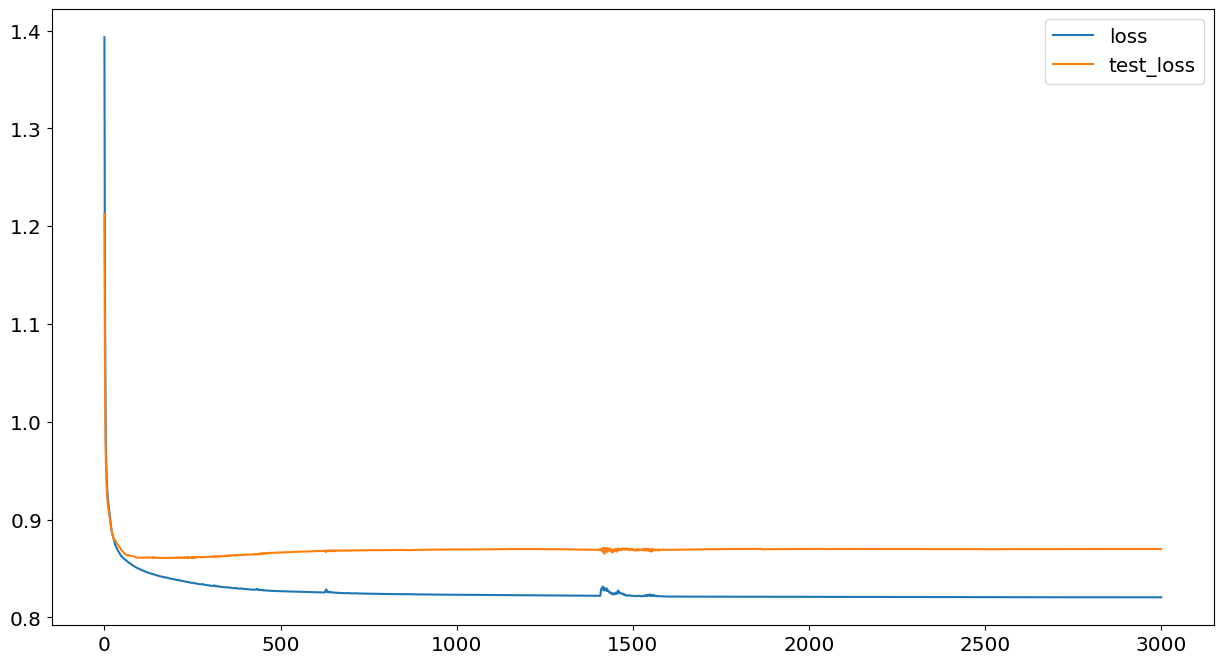

In [127]:
loss_df.plot(y = ['loss','test_loss']);

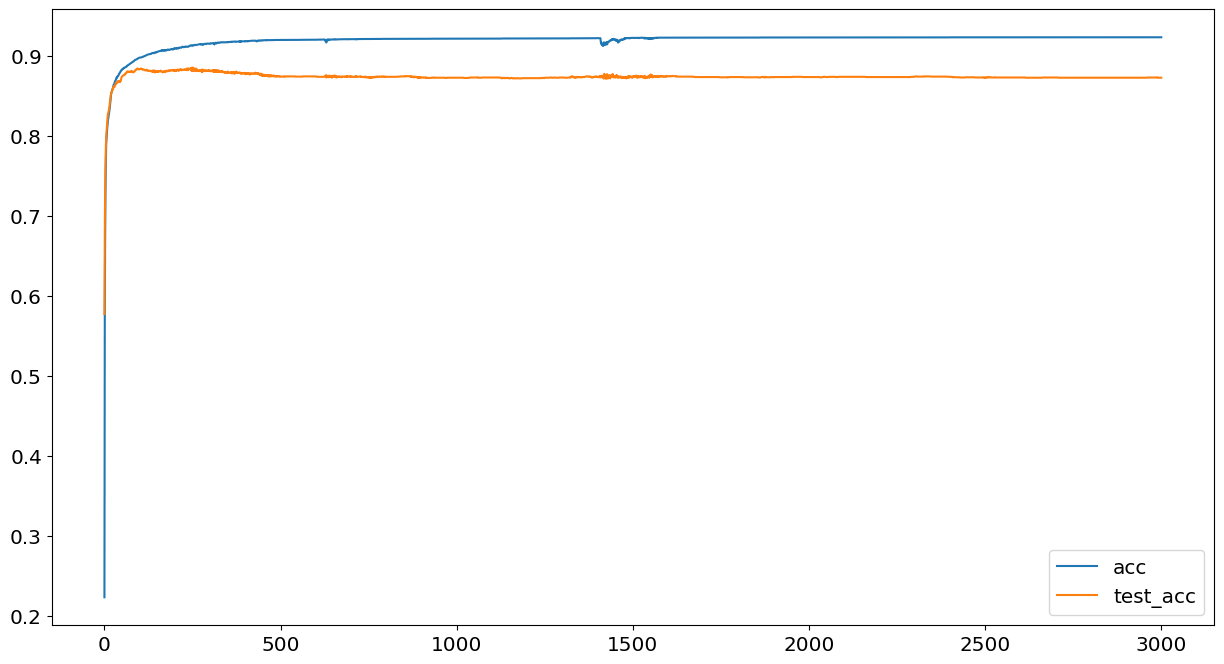

In [128]:
loss_df.plot(y = ['acc','test_acc']);

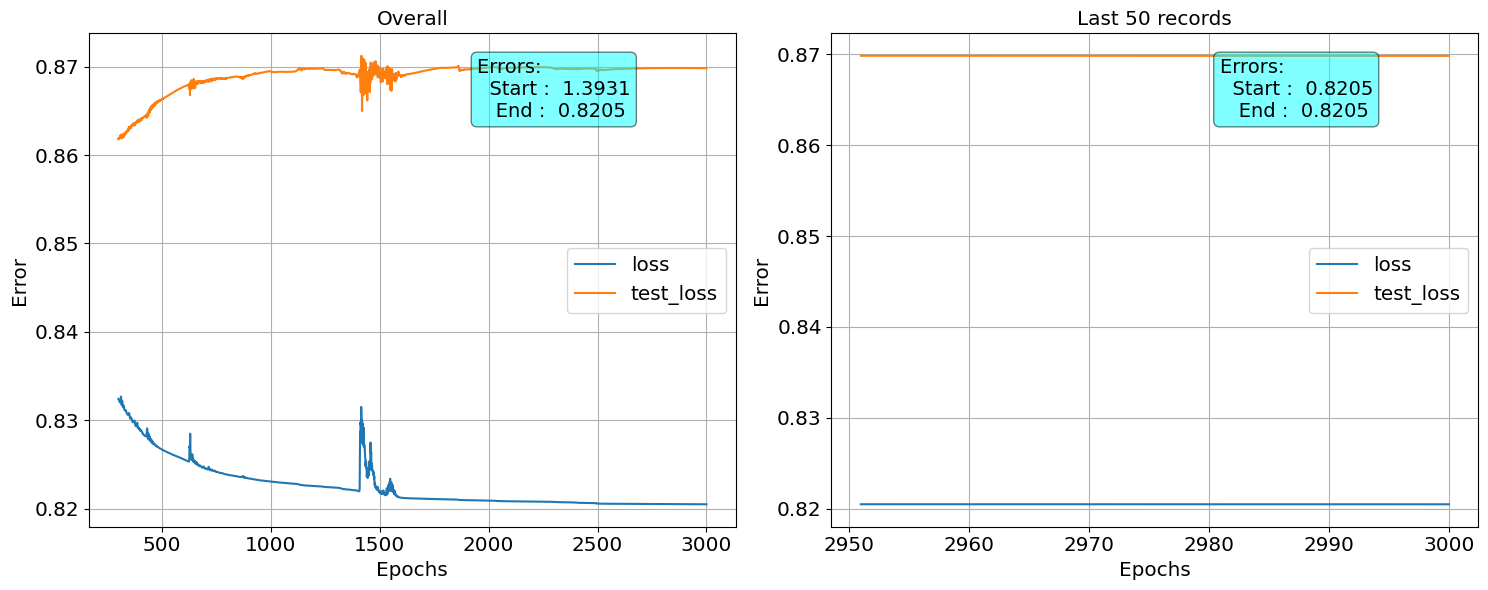

In [129]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 50

ax = axes[0]

loss_df[300:].plot(x = 'epoch', y = ['loss', 'test_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = ['loss', 'test_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[-l_range]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

In [130]:
loss_df[loss_df['test_loss'] == loss_df['test_loss'].min()]

,epoch,loss,test_loss,acc,test_acc
164,164,0.841435,0.860602,0.907006,0.87989


In [131]:
## Confusion Matrix helps

cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (2).

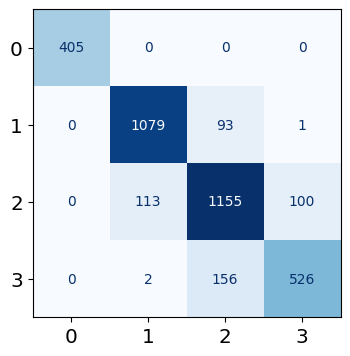

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();